# Определение перспективного тарифа для телеком-компании

## Введение

###### Описание проекта

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import math as mh
from scipy import stats as st
from matplotlib import pyplot as plt

Открываем файлы и сохраняем данные в датафреймы

In [2]:
df_users = pd.read_csv('/datasets/users.csv')
df_tariffs = pd.read_csv('/datasets/tariffs.csv')
df_calls = pd.read_csv('/datasets/calls.csv')
df_messages = pd.read_csv('/datasets/messages.csv')
df_internet = pd.read_csv('/datasets/internet.csv')

## Изучение, проверка и корректировка данных в датфреймах

### Таблица users

#### Общая информация

Таблица `users` (информация о пользователях):
* `user_id` — уникальный идентификатор пользователя
* `first_name` — имя пользователя
* `last_name` — фамилия пользователя
* `age` — возраст пользователя (годы)
* `reg_date` — дата подключения тарифа (день, месяц, год)
* `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* `city` — город проживания пользователя
* `tarif` — название тарифного плана

In [3]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [4]:
df_users.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


Проверим столбцы `age` и `tariff` на некорректные данные

In [5]:
df_users.query('age < 18 or age > 100')['age'].count()

0

In [6]:
df_users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

###### Вывод

* ошибок в данных не обнаруженно
* есть пропуске в столбце `churn_date`, они означают: что тариф ещё действовал на момент выгрузки данных, поэтому не будем от них избавляться

#### Создания словаря

Создадим словарь со столбцами `user_id`, `city` и `tariff`

In [7]:
df_users_tariff = df_users[['user_id','city', 'tariff']]

In [8]:
df_users_tariff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
user_id    500 non-null int64
city       500 non-null object
tariff     500 non-null object
dtypes: int64(1), object(2)
memory usage: 11.8+ KB


In [9]:
df_users_tariff.head()

,user_id,city,tariff
0,1000,Краснодар,ultra
1,1001,Москва,smart
2,1002,Стерлитамак,smart
3,1003,Москва,ultra
4,1004,Новокузнецк,ultra


### Таблица tariffs

#### Общая информация

Таблица `tariffs` (информация о тарифах):
* `tariff_name` — название тарифа
* `rub_monthly_fee` — ежемесячная абонентская плата в рублях
* `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
* `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
* `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
* `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [10]:
df_tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [11]:
df_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


###### Вывод

* пропусков и ошибок в данных не обнаруженно
* для удобства переведём интернет трафик из MB в GB

#### Предобработка данных

Переведём интернет трафик из MB в GB

In [12]:
df_tariffs['mb_per_month_included'] = (df_tariffs['mb_per_month_included'] / 1024).astype(int)
df_tariffs = df_tariffs.rename(columns={"mb_per_month_included": "gb_per_month_included"})

In [13]:
df_tariffs.head()

,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15,500,550,200,3,3,smart
1,1000,30,3000,1950,150,1,1,ultra


### Таблица calls

#### Общая информация

Таблица `calls` (информация о звонках):
* `id` — уникальный номер звонка
* `call_date` — дата звонка
* `duration` — длительность звонка в минутах
* `user_id` — идентификатор пользователя, сделавшего звонок

In [14]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [15]:
df_calls.head(10)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


Проверим длительность звонков, на некорректные значения

In [16]:
df_calls.query('duration < 0 or duration > 1000')['duration'].count()

0

###### Вывод

* пропусков и ошибок в данных не обнаруженно
* необходимо длительность звонков округлить до целых чисел, исходя из правил тарификации, и перевсти данный столбец в тип int
* необходимо создать столбец с месяцом звонка
* в таблице обнаружены нули в продолжительности звонков, нулями обозначены пропущенные звонки, поэтому их не нужно удалять. Они нам не помешают, так как мы будем суммировать звонки за месяц и нули исчезнут.

#### Предобработка данных

Округлим длительность звонков до целых чисел (в большую сторону) и переведем столбец 'duration' в тип int

In [17]:
df_calls['duration'] = np.ceil(df_calls.duration).astype(int)

In [18]:
df_calls.head(10)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000
5,1000_5,2018-11-02,0,1000
6,1000_6,2018-10-18,0,1000
7,1000_7,2018-08-22,19,1000
8,1000_8,2018-09-15,19,1000
9,1000_9,2018-08-15,0,1000


#### Добавление новых столбцов

Добавим столбец с месяцем совершения звонка

In [19]:
df_calls['month'] = pd.DatetimeIndex(df_calls.call_date).month

#### Агригирование таблицы

Посчитаем для каждого пользователя,количество сделанных звонков и израсходованных минут разговора по месяцам

In [20]:
df_calls_sum = df_calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc='sum').reset_index().copy()
df_calls_sum.head()

,user_id,month,duration
0,1000,5,159
1,1000,6,172
2,1000,7,340
3,1000,8,408
4,1000,9,466


### Таблица messages

#### Общая информация

Таблица `messages` (информация о сообщениях):
* `id` — уникальный номер сообщения
* `message_date` — дата сообщения
* `user_id` — идентификатор пользователя, отправившего сообщение

In [21]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [22]:
df_messages.head(10)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


###### Вывод

* пропусков и ошибок в данных не обнаруженно
* необходимо создать столбец с месяцем отправки сообщения

#### Добавление новых столбцов

Добавим столбец с месяцем отправки сообщения

In [23]:
df_messages['month'] = pd.DatetimeIndex(df_messages.message_date).month

#### Агригирование таблицы

Посчитаем для каждого пользователя,количество отправленных сообщений по месяцам

In [24]:
df_messages_sum = df_calls.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count').reset_index().copy()

Переименуем столбец

In [25]:
df_messages_sum = df_messages_sum.rename(columns={"id": "count_messages"})
df_messages_sum.head()

,user_id,month,count_messages
0,1000,5,22
1,1000,6,43
2,1000,7,47
3,1000,8,52
4,1000,9,58


### Таблица internet

#### Общая информация

Таблица `internet` (информация об интернет-сессиях):
* `id` — уникальный номер сессии
* `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
* `session_date` — дата интернет-сессии
* `user_id` — идентификатор пользователя

In [26]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [27]:
df_internet.head(10)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


Проверка данных на некорректные значения

In [28]:
df_internet.query('mb_used < 0')['mb_used'].count()

0

###### Вывод

* пропусков и ошибок в данных не обнаруженно
* обнаружен столбец дублирующий индекс, удалять его не будем, так как нам необходимо агрегировать таблицу и его уже в ней не будет
* необходимо создать столбец с месяцем использования интернет сессии

#### Добавление новых столбцов

Добавим столбец с месяцем использования интернет сессии

In [29]:
df_internet['month'] = pd.DatetimeIndex(df_internet.session_date).month

#### Агригирование таблицы

Посчитаем для каждого пользователя,количество интернет трафика по месяцам и переведём это значение в ГБ

In [30]:
df_internet_sum = df_internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum').reset_index().copy()
df_internet_sum['mb_used'] /= 1024
df_internet_sum['mb_used'] = np.ceil(df_internet_sum.mb_used).astype(int)
df_internet_sum = df_internet_sum.rename(columns={"mb_used": "gb_used"})
df_internet_sum.head()

,user_id,month,gb_used
0,1000,5,3
1,1000,6,23
2,1000,7,14
3,1000,8,14
4,1000,9,15


### Объединение таблиц

Объеденим таблицы: `df_calls_sum`, `df_messages_sum`, `df_internet_sum` и `df_users_tariff` в одну таблицу

In [31]:
df_connection_month = pd.merge(
    df_calls_sum, df_messages_sum, how='outer'
).merge(df_internet_sum, how='outer').merge(df_users_tariff, how='inner')

In [32]:
df_connection_month.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 7 columns):
user_id           3214 non-null int64
month             3214 non-null int64
duration          3174 non-null float64
count_messages    3174 non-null float64
gb_used           3203 non-null float64
city              3214 non-null object
tariff            3214 non-null object
dtypes: float64(3), int64(2), object(2)
memory usage: 200.9+ KB


Заполним пропуски нулями, так возможно часть пользователей, используют телефон без доступа в интернет или наоборот используют сим-карту, только для выхода в интернет. Сменим тип float на int

In [33]:
df_connection_month = df_connection_month.fillna(0)
df_connection_month[['duration', 'count_messages', 'gb_used']] = df_connection_month[['duration', 'count_messages', 'gb_used']].astype('int')

In [34]:
df_connection_month.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 7 columns):
user_id           3214 non-null int64
month             3214 non-null int64
duration          3214 non-null int64
count_messages    3214 non-null int64
gb_used           3214 non-null int64
city              3214 non-null object
tariff            3214 non-null object
dtypes: int64(5), object(2)
memory usage: 200.9+ KB


In [35]:
df_connection_month.head()

,user_id,month,duration,count_messages,gb_used,city,tariff
0,1000,5,159,22,3,Краснодар,ultra
1,1000,6,172,43,23,Краснодар,ultra
2,1000,7,340,47,14,Краснодар,ultra
3,1000,8,408,52,14,Краснодар,ultra
4,1000,9,466,58,15,Краснодар,ultra


### Таблица connection_month

Создадим функцию, которая считает помесячную выручку с каждого пользователя

In [36]:
def revenue(connection_month, tariffs):
    tariff_name = connection_month['tariff']
    tariff = tariffs.query('tariff_name == @tariff_name').reset_index().loc[0]
    revenue_sum = tariff['rub_monthly_fee']
    
    if connection_month['duration'] > tariff['minutes_included']:
        revenue_sum = revenue_sum + (connection_month['duration'] - tariff['minutes_included']) * tariff['rub_per_minute']
    
    if connection_month['count_messages'] > tariff['messages_included']:
        revenue_sum = revenue_sum + (connection_month['count_messages'] - tariff['messages_included']) * tariff['rub_per_message']
    
    if connection_month['gb_used'] > tariff['gb_per_month_included']:
        revenue_sum = revenue_sum + (connection_month['gb_used'] - tariff['gb_per_month_included']) * tariff['rub_per_gb']
    
    return revenue_sum

Добавим столбец с помесячной выручкой в таблицу `df_connection_month`

In [37]:
df_connection_month['revenue'] = df_connection_month.apply(lambda x: revenue(x, df_tariffs), axis=1)

In [38]:
df_connection_month.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 8 columns):
user_id           3214 non-null int64
month             3214 non-null int64
duration          3214 non-null int64
count_messages    3214 non-null int64
gb_used           3214 non-null int64
city              3214 non-null object
tariff            3214 non-null object
revenue           3214 non-null int64
dtypes: int64(6), object(2)
memory usage: 226.0+ KB


In [39]:
df_connection_month.head(10)

,user_id,month,duration,count_messages,gb_used,city,tariff,revenue
0,1000,5,159,22,3,Краснодар,ultra,1950
1,1000,6,172,43,23,Краснодар,ultra,1950
2,1000,7,340,47,14,Краснодар,ultra,1950
3,1000,8,408,52,14,Краснодар,ultra,1950
4,1000,9,466,58,15,Краснодар,ultra,1950
5,1000,10,350,57,15,Краснодар,ultra,1950
6,1000,11,338,43,15,Краснодар,ultra,1950
7,1000,12,333,46,10,Краснодар,ultra,1950
8,1001,11,430,59,18,Москва,smart,1177
9,1001,12,414,63,14,Москва,smart,589


## Анализ данных

Разделим таблицу `df_connection_month`на две выборки, в оду добавим пользователей с тарифом ultra, а в другую с тарифом smart

In [40]:
connection_month_ultra = df_connection_month.query('tariff == "ultra"').copy()
connection_month_smart = df_connection_month.query('tariff == "smart"').copy()

### Пользователи с тарифом Ultra

#### Метрики

Найдем средние значение и стандартное отклонение для: звонков, сообщений и интернет трафика

In [41]:
connection_month_ultra[['duration', 'count_messages', 'gb_used', 'revenue']].describe()

,duration,count_messages,gb_used,revenue
count,985.000000,985.000000,985.000000,985.000000
mean,526.623350,73.392893,19.494416,2070.152284
std,317.606098,43.916853,9.853511,376.187114
min,0.000000,0.000000,0.000000,1950.000000
25%,284.000000,41.000000,12.000000,1950.000000
50%,518.000000,74.000000,19.000000,1950.000000
75%,752.000000,104.000000,27.000000,1950.000000
max,1673.000000,244.000000,49.000000,4800.000000


Найдем дисперсию для: звонков, сообщений и интернет трафика

In [43]:
np.var(connection_month_ultra[['duration', 'count_messages', 'gb_used', 'revenue']])

duration          100771.223617
count_messages      1926.731929
gb_used               96.993116
revenue           141373.073256
dtype: float64

###### Вывод
* В среднем пользователям на тарифе Ultra, требуется: 527 минут (стандартное отклонение 318 минут), 73 сообщения (стандартное отклонение 39 сообщений), 19 ГБ интернета (стандартное отклонение 10 ГБ);
* В среднем пользователи на тарифе Ultra тратят по 2070 р. в месяц (стандартное отклонение 376 р.).

#### Гистограммы

##### Звонки

Text(0, 0.5, 'Кол-во пользователей')

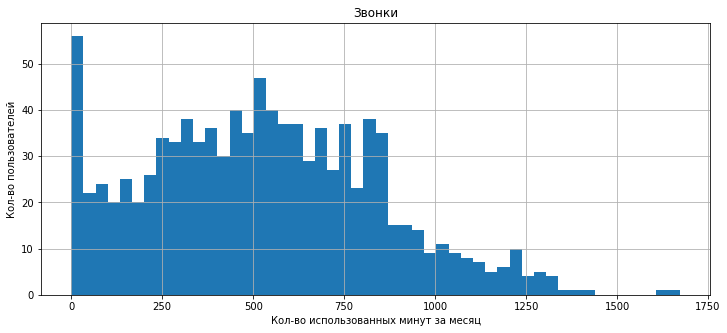

In [44]:
connection_month_ultra['duration'].plot(bins=50, figsize=(12, 5), title='Звонки', kind='hist', grid=True)
plt.xlabel("Кол-во использованных минут за месяц")
plt.ylabel("Кол-во пользователей")

Данные распределенны нормально, но иммеют небольшую скошенность в право. Так же присутствую выбивающиеся значения: 0 и выше 1500 минут.

##### Сообщения

Text(0, 0.5, 'Кол-во пользователей')

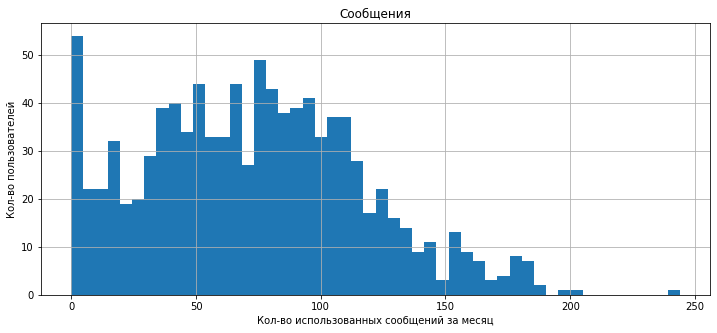

In [45]:
connection_month_ultra['count_messages'].plot(bins=50, figsize=(12, 5), title='Сообщения', kind='hist', grid=True)
plt.xlabel("Кол-во использованных сообщений за месяц")
plt.ylabel("Кол-во пользователей")

Данные распределенны нормально, но иммеют небольшую скошенность в право. Так же присутствую выбивающиеся значения: 0 и выше 200 сообщений.

##### Интернет

Text(0, 0.5, 'Кол-во пользователей')

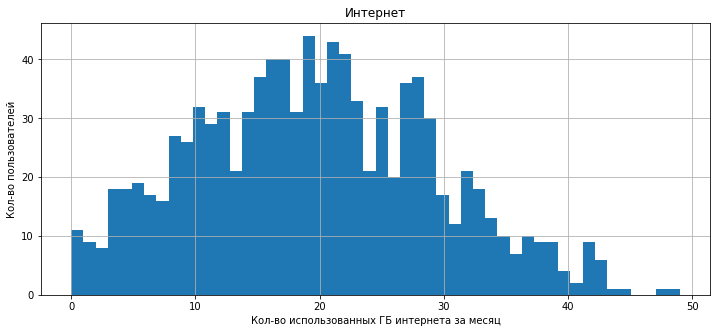

In [46]:
connection_month_ultra['gb_used'].plot(bins=50, figsize=(12, 5), title='Интернет', kind='hist', grid=True)
plt.xlabel("Кол-во использованных ГБ интернета за месяц")
plt.ylabel("Кол-во пользователей")

Данные распределенны нормально.

##### Выручка

Text(0, 0.5, 'Кол-во пользователей')

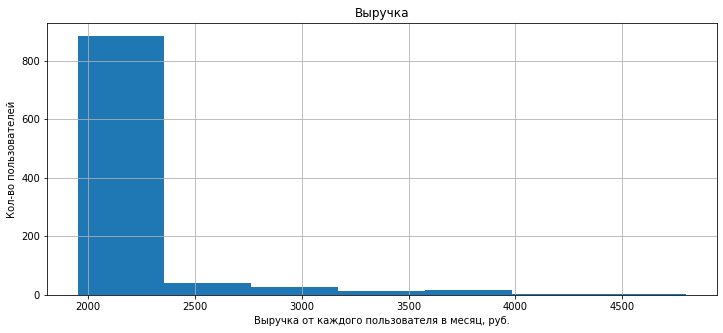

In [47]:
connection_month_ultra['revenue'].plot(bins=7, figsize=(12, 5), title='Выручка', kind='hist', grid=True)
plt.xlabel("Выручка от каждого пользователя в месяц, руб.")
plt.ylabel("Кол-во пользователей")

Выборка распределенна нормально, но имеет сильную скошенность в право

### Пользователи с тарифом Smart

#### Метрики

Найдем средние значение и стандартное отклонение для: звонков, сообщений и интернет трафика

In [48]:
connection_month_smart[['duration', 'count_messages', 'gb_used', 'revenue']].describe()

,duration,count_messages,gb_used,revenue
count,2229.000000,2229.000000,2229.000000,2229.000000
mean,417.934948,58.463437,16.328847,1318.608793
std,190.313730,25.939858,5.747061,837.746263
min,0.000000,0.000000,0.000000,550.000000
25%,282.000000,40.000000,13.000000,583.000000
50%,422.000000,60.000000,17.000000,1079.000000
75%,545.000000,76.000000,20.000000,1792.000000
max,1435.000000,198.000000,38.000000,6920.000000


Найдем дисперсию для: звонков, сообщений и интернет трафика

In [49]:
np.var(connection_month_smart[['duration', 'count_messages', 'gb_used', 'revenue']])

duration           36203.066652
count_messages       672.574370
gb_used               33.013887
revenue           701503.942964
dtype: float64

###### Вывод
* В среднем пользователям на тарифе Smart, требуется: 418 минут (стандартное отклонение 190 минут), 58 сообщения (стандартное отклонение 26 сообщений), 16 ГБ интернета (стандартное отклонение 6 ГБ);
* В среднем пользователи на тарифе Smart тратят по 1318 р. в месяц (стандартное отклонение 837 р.).

#### Гистограммы

##### Звонки

Text(0, 0.5, 'Кол-во пользователей')

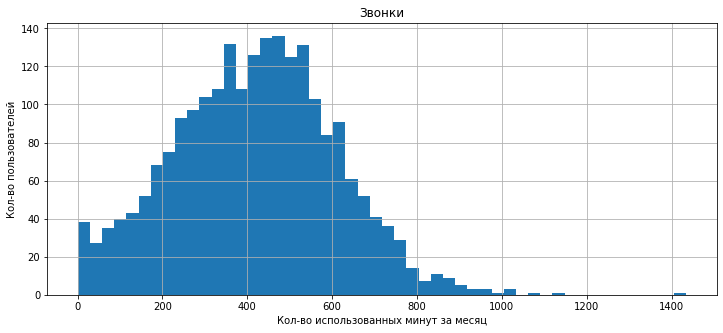

In [50]:
connection_month_smart['duration'].plot(bins=50, figsize=(12, 5), title='Звонки', kind='hist', grid=True)
plt.xlabel("Кол-во использованных минут за месяц")
plt.ylabel("Кол-во пользователей")

Данные распределенны нормально. Присутствую выбивающиеся значения: 0 и выше 800 минут.

##### Сообщения

Text(0, 0.5, 'Кол-во пользователей')

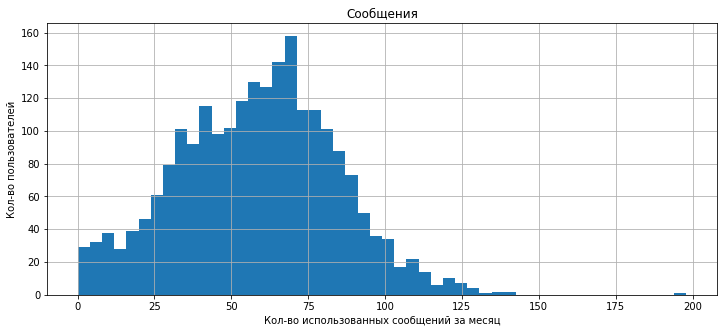

In [51]:
connection_month_smart['count_messages'].plot(bins=50, figsize=(12, 5), title='Сообщения', kind='hist', grid=True)
plt.xlabel("Кол-во использованных сообщений за месяц")
plt.ylabel("Кол-во пользователей")

Данные распределенны нормально. Присутствую выбивающиеся значения: выше 125 сообщений.

##### Интернет

Text(0, 0.5, 'Кол-во пользователей')

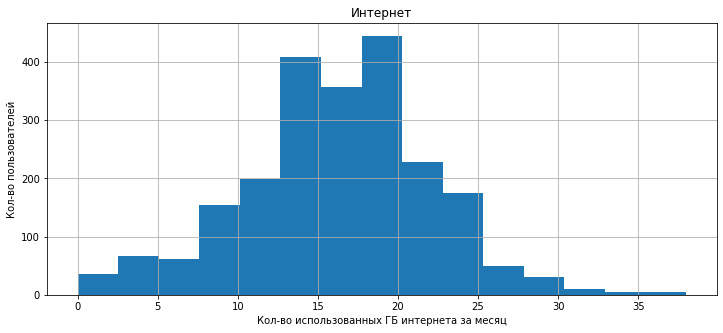

In [52]:
connection_month_smart['gb_used'].plot(bins=15, figsize=(12, 5), title='Интернет', kind='hist', grid=True)
plt.xlabel("Кол-во использованных ГБ интернета за месяц")
plt.ylabel("Кол-во пользователей")

Данные распределенны нормально.

##### Выручка

Text(0, 0.5, 'Кол-во пользователей')

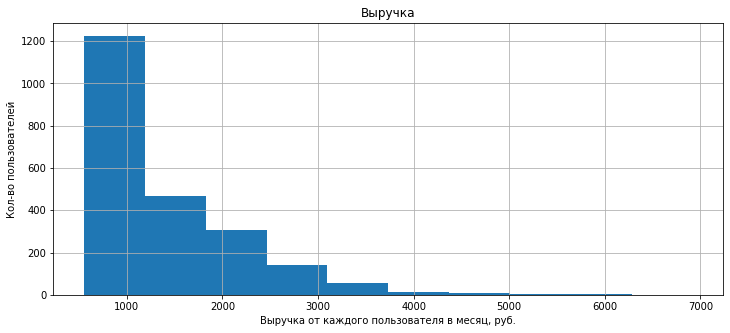

In [53]:
connection_month_smart['revenue'].plot(bins=10, figsize=(12, 5), title='Выручка', kind='hist', grid=True)
plt.xlabel("Выручка от каждого пользователя в месяц, руб.")
plt.ylabel("Кол-во пользователей")

Выборка распределенна нормально, но имеет сильную скошенность в право

### Вывод

* Пользователи на тарифе Smart платят в среднем меньше денег, чем пользователи на тарифе Ultra, 1318 р., против 2070 р. в месяц;
* Пользователям на тарифе Ultra требуется больше минут разговора, сообщений и интернет трафика; 
    * В среднем пользователям на тарифе Ultra, требуется: 527 минут (стандартное отклонение 318 минут), 73 сообщения (стандартное отклонение 39 сообщений), 19 ГБ интернета (стандартное отклонение 10 ГБ);
    * В среднем пользователям на тарифе Smart, требуется: 418 минут (стандартное отклонение 190 минут), 58 сообщения (стандартное отклонение 26 сообщений), 16 ГБ интернета (стандартное отклонение 6 ГБ);
* Дисперсии двух выборок сильно различаются;
* Выборки распределены нормально, но имеют скошенность в право.

## Проверка гипотез

Разделим таблицу `df_connection_month`на две выборки, в первую добавим пользователей из Москвы, во вторую - пользователей из других регионов

In [55]:
connection_month_moscow = df_connection_month.query('city == "Москва"').copy()
connection_month_regions = df_connection_month.query('city != "Москва"').copy()

### Сравнение средней выручки тарифов Ultra и Smart

Проверим гипотезу, что средняя выручка пользователей тарифов Ultra и Smart различаются.
* За нулевую гипотезу возьмём, что средняя выручка пользователей тарифов Ultra и Smart не различается (равны);
* За альтернативную гипотезу возьмём обратное утверждение, что средняя выручка пользователей тарифов Ultra и Smart различается;
* Критический уровень статической значимости (alpha) зададим 1%.

In [56]:
alpha = 0.01
results = st.ttest_ind(connection_month_ultra['revenue'], connection_month_smart['revenue'], equal_var = False)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.0519833366062768e-228
Отвергаем нулевую гипотезу


###### Вывод
* Нулевая гипотеза отвергнута, значит средняя выручка пользователей тарифов Ultra и Smart различается.

### Сравнение средней выручки пользователей из Москвы и регионов

Проверим гипотезу, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
* За нулевую гипотезу возьмём, что средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов;
* За альтернативную гипотезу возьмём обратное утверждение,  что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионова;
* Критический уровень статической значимости (alpha) зададим 1%.

In [57]:
alpha = 0.01
results = st.ttest_ind(connection_month_moscow['revenue'], connection_month_regions['revenue'], equal_var = False)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5305308576929098
Не получилось отвергнуть нулевую гипотезу


###### Вывод
* Нулевую гипотезу не удалось отвергнуть. Это явно слишком большая вероятность (53%), чтобы делать вывод о значимом различии между средней выручкой у пользователей из Москвы и регионов.

## Общий вывод

* Пользователи на тарифе Ultra приносят большую выручку, чем пользователи на тарифе Smart, 2070 р. и 1318 р. соответственно;
* Пользователи на тарифе Ultra тратят больше минут разговора, сообщений и интернет трафика, чем пользователи на тарифе Smart:
    * В среднем пользователям на тарифе Ultra, требуется: 527 минут (стандартное отклонение 318 минут), 73 сообщения (стандартное отклонение 39 сообщений), 19 ГБ интернета (стандартное отклонение 10 ГБ);
    * В среднем пользователям на тарифе Smart, требуется: 418 минут (стандартное отклонение 190 минут), 58 сообщения (стандартное отклонение 26 сообщений), 16 ГБ интернета (стандартное отклонение 6 ГБ).
* Гипотеза, что средняя выручка пользователей на тарифе Ultra и Smart не различается (равна) - отвергнута, значит средняя выручка пользователей тарифов Ultra и Smart различается.
* Гипотезу о том, что что средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов не удалось отвергнуть. Нельзя сделать вывод о значимом различии между средней выручкой у пользователей из Москвы и регионов.


Тариф Ultra выгоднее для компании, так как приносит гораздо большую выручку и подталкивает пользователей на большее расходование минут, сообщений и интернет трафика.